In [23]:
import requests
import cv2
from moviepy.editor import VideoFileClip
import time
import base64
import os
from IPython.display import Image, display, Audio, Markdown
from dotenv import load_dotenv
from openai import OpenAI 

In [24]:
load_dotenv()

True

In [25]:
MODEL="gpt-4o"
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [31]:
# URL of the online video
VIDEO_URL = "https://redacted.blob.core.windows.net/videointerviews/InterView_PythonGCsM365Conf.MOV"
VIDEO_PATH = "downloaded_video.MOV"

In [12]:
# Download the video from the URL
def download_video(url, video_path):
    response = requests.get(url, stream=True)
    with open(video_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Video downloaded to {video_path}")

In [13]:
# Process the video
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame = 0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

In [14]:
# Download the video
download_video(VIDEO_URL, VIDEO_PATH)

Video downloaded to downloaded_video.MOV


In [15]:
# Extract 1 frame per second. the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)

MoviePy - Writing audio in downloaded_video.mp3


MoviePy - Done.
Extracted 24 frames
Extracted audio to downloaded_video.mp3


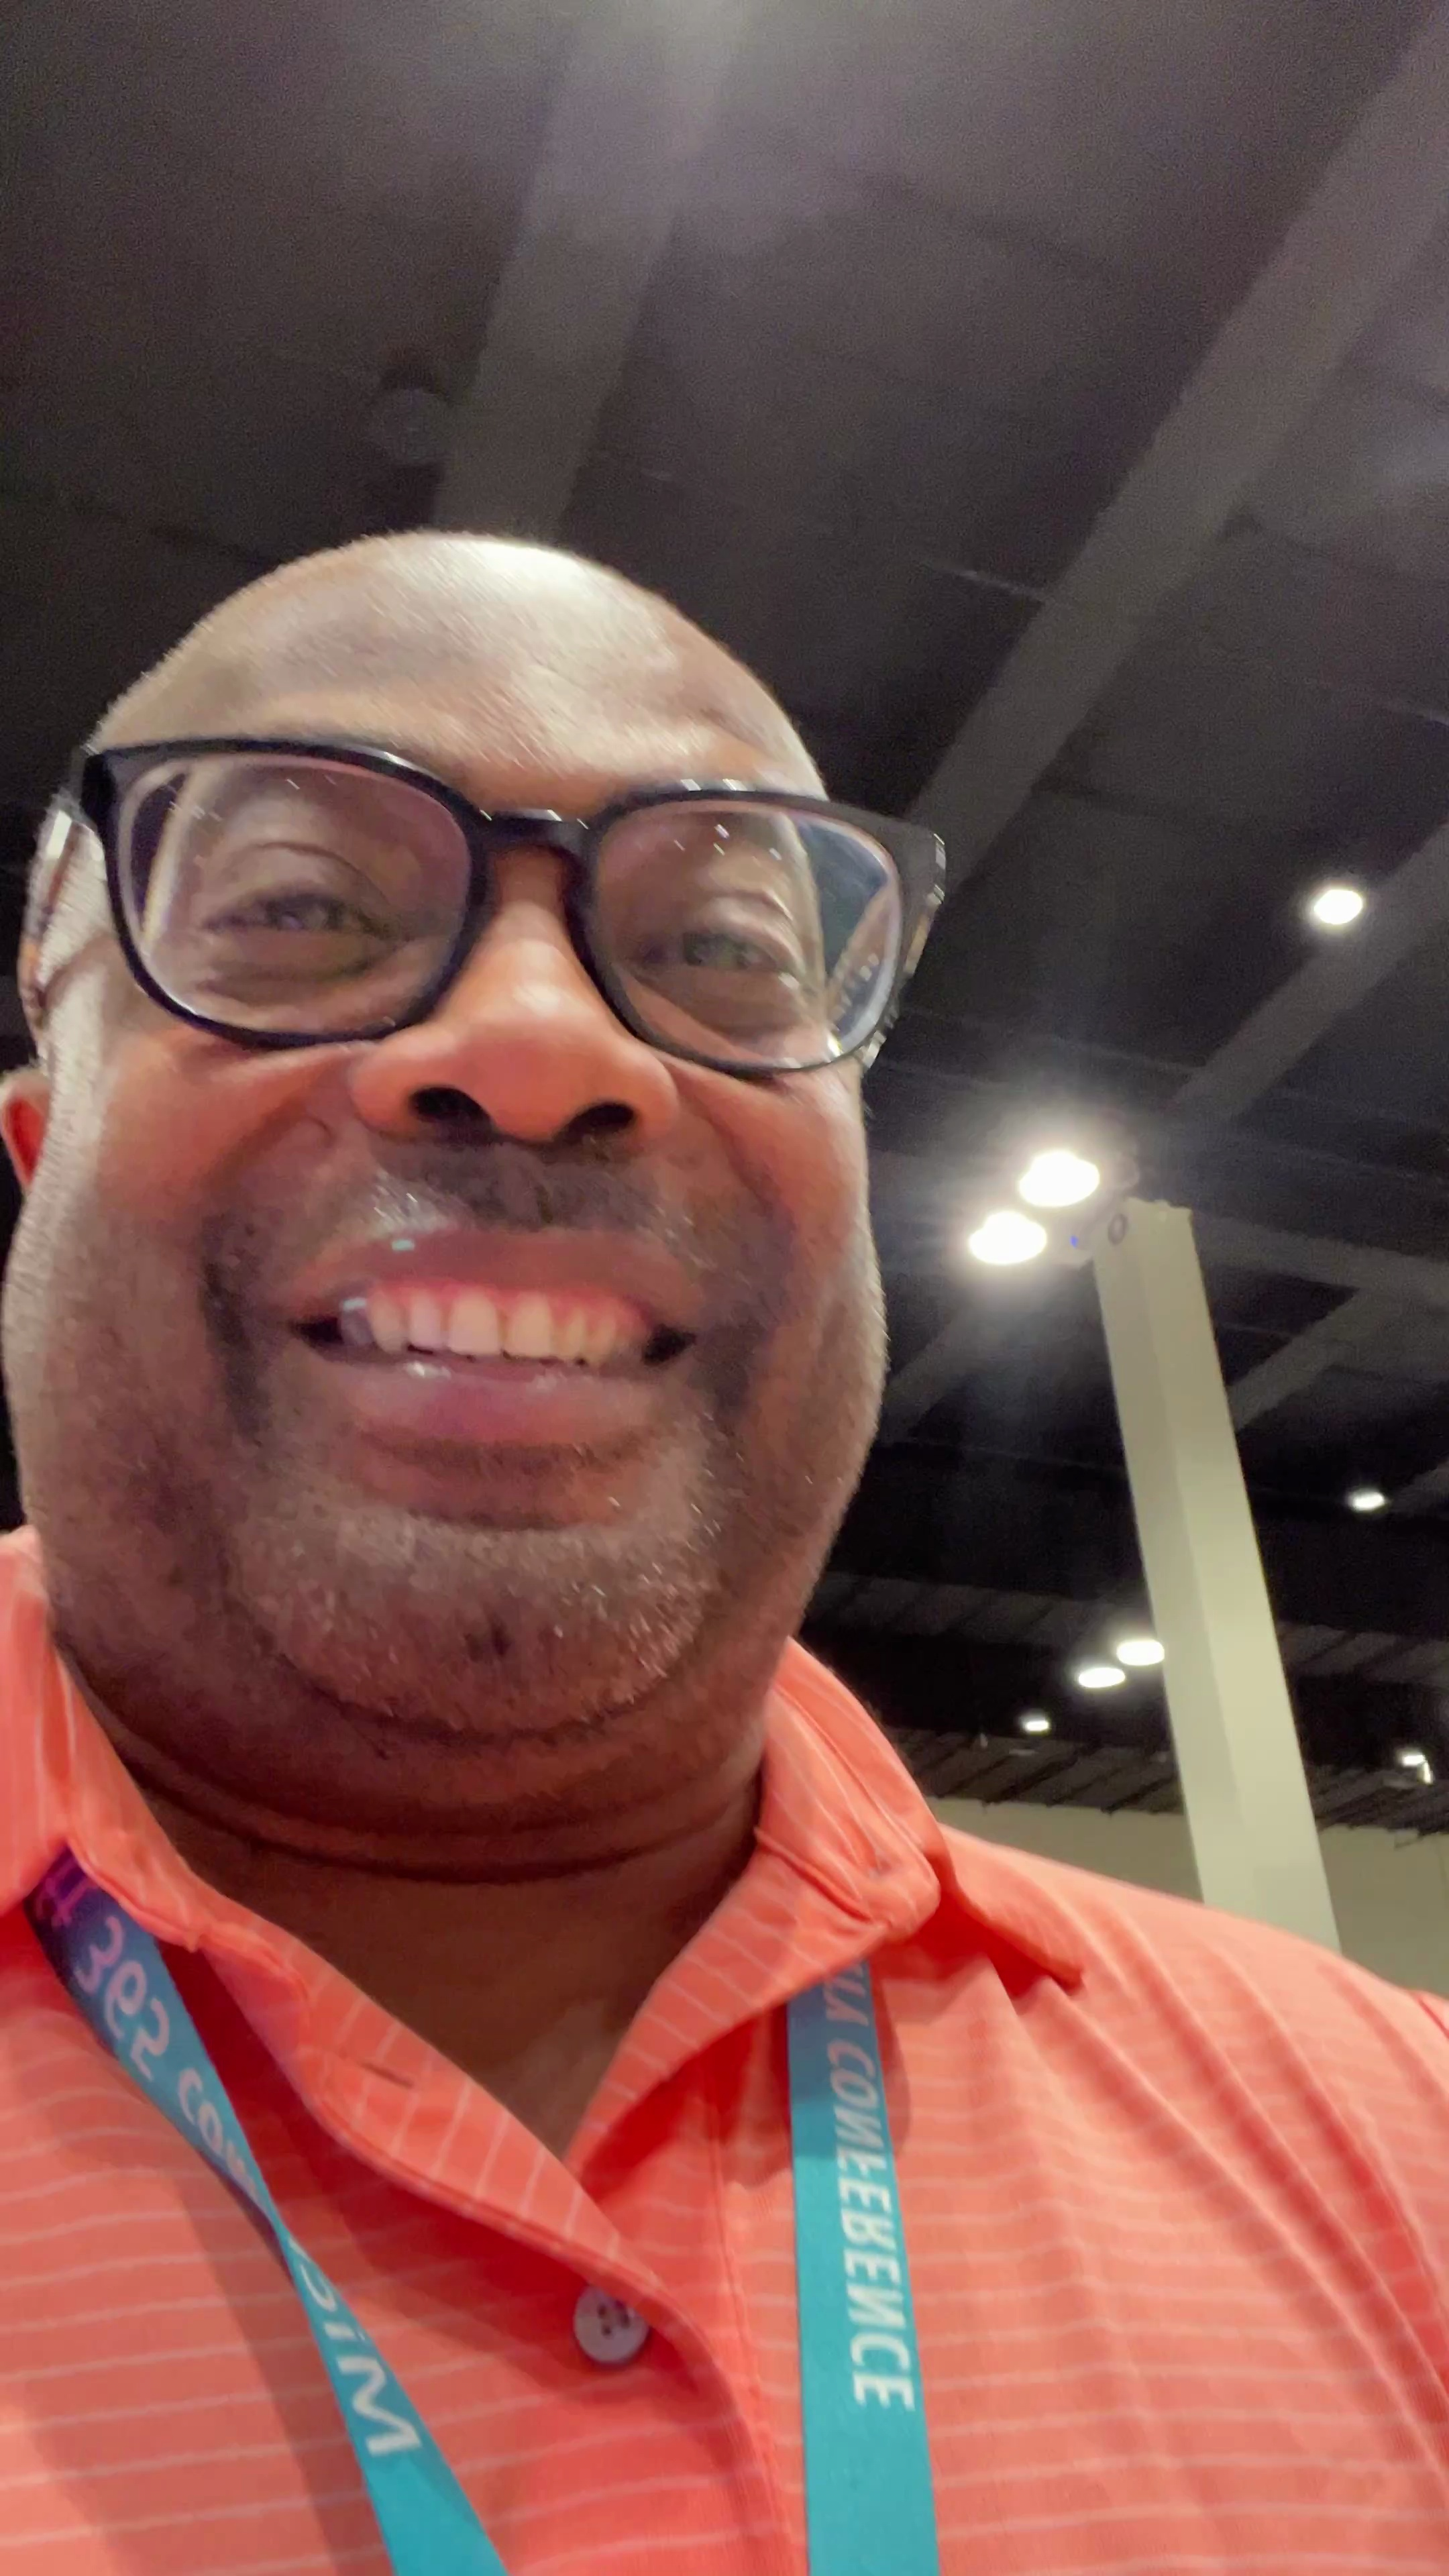

In [19]:
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_path)

### Summarization - VISUAL

In [26]:
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video. Respond in Markdown."},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

### Video Summary

The video appears to be a conversation between two individuals at a conference or trade show. Here is a summary based on the provided frames:

1. **Introduction and Greetings**: The video starts with two individuals, one in an orange shirt and the other in a white shirt with a lanyard, greeting each other. They seem to be at a booth or exhibit area.

2. **Discussion**: The two individuals engage in a conversation. The person in the white shirt appears to be explaining something, possibly related to the conference or the products/services being showcased. The person in the orange shirt listens attentively and occasionally responds.

3. **Interaction with Others**: As the conversation continues, other people in the background are seen engaging in their own discussions. The environment is busy, indicating a well-attended event.

4. **Conclusion**: Towards the end of the video, the person in the orange shirt turns the camera to include another individual, who gives a thu

### Summarization - AUDIO

#### This uses Whisper as of now GPT4o does not do both video and audio

In [27]:
# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
)
## OPTIONAL: Uncomment the line below to print the transcription
#print("Transcript: ", transcription.text + "\n\n")

response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."""},
    {"role": "user", "content": [
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

The speaker praises the usefulness of Python code connectors, describing them as "absolute magic." They mention leveraging these connectors for a presentation on extracting domino data from legacy systems and integrating it with a user connector. Additionally, they acknowledge Waldeck MasterCards for their contribution, giving a big thumbs up to Waldeck.


### Summarization -- Combined VIDEO and AUDIO

In [28]:
## Generate a summary with visual and audio
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

### Video Summary

The video appears to be taken at a conference or an event, where two individuals are having a conversation. The setting is a busy exhibition hall with various booths and attendees in the background. 

#### Key Points:
1. **Introduction and Setup**:
   - The video starts with the person holding the camera asking the other individual what they want to say.
   
2. **Discussion on Python Code Connectors**:
   - The individual being interviewed praises the Python code connectors, describing them as "absolute magic."
   - He mentions using these connectors to extract data from legacy systems and present it using a user connector.
   
3. **Acknowledgment**:
   - The individual gives credit to Waldeck MasterCards for their contribution to the project.
   - He gives a big thumbs up to Waldeck, showing appreciation for their work.

#### Visuals:
- The video features two main individuals, one in an orange shirt and the other in a white shirt with a lanyard.
- The background sho

### Question and Answer from the Transcript

In [29]:
QUESTION = "Question: What is the main theme of the conversation and how would you say the mood was?"

In [30]:
qa_both_response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""Use the video and transcription to answer the provided question."""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
                        {"type": "text", "text": f"The audio transcription is: {transcription.text}"},
        QUESTION
        ],
    }
    ],
    temperature=0,
)
print("Both QA:\n" + qa_both_response.choices[0].message.content)

Both QA:
The main theme of the conversation is the usefulness and effectiveness of Python code connectors, particularly in the context of extracting data from legacy systems and utilizing it in new applications. The speaker also gives credit to someone named Waldeck for their contributions.

The mood of the conversation appears to be positive and enthusiastic. The speaker is expressing appreciation and satisfaction with the tools and contributions mentioned, and there are smiles and gestures of approval, such as a thumbs up, indicating a friendly and upbeat atmosphere.
